In [79]:
from scipy.ndimage.interpolation import map_coordinates, zoom

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import struct
import scipy.ndimage
from scipy.ndimage.interpolation import zoom as zoom
from scipy.ndimage.interpolation import map_coordinates

import torch
import torch.nn as nn
import torch.nn.functional as F
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="* -4"))
print(torch.__version__)
import sys
import time
from scipy.ndimage import distance_transform_edt as edt

A = torch.ones(64,64).cuda()
A.requires_grad = True
A.sum().backward()
sys.path.append('/share/data_supergrover1/heinrich/voxelmorph/pytorch/')
import losses
print(losses.mind_loss)

def gpu_usage():
    print('gpu usage (current/max): {:.2f} / {:.2f} GB'.format(torch.cuda.memory_allocated()*1e-9, torch.cuda.max_memory_allocated()*1e-9))

    
import os
import pandas as pd
from scipy.ndimage.interpolation import zoom


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  -------------------
   2  NVIDIA GeForce RTX 2080 Ti     0 %   11016 MiB  11.5(495.29.05)
   1  NVIDIA GeForce RTX 2080 Ti     0 %    9201 MiB  11.5(495.29.05)  weihsbach
   0  NVIDIA GeForce RTX 2080 Ti     0 %    1264 MiB  11.5(495.29.05)  ehrhardt, schneider
   3  NVIDIA GeForce RTX 2080 Ti  ! 61 %    2135 MiB  11.5(495.29.05)  ehrhardt

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   2  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0
1.9.0a0+gitdfbd030
<function mind_loss at 0x7fccfcbb4160>


In [110]:
LOAD_LEFT = False
valid_t1 = []
folder_t1 = '/share/data_supergrover1/hansen/temp/crossMoDa/preprocessed_new/resampled/localised_crop/source_training/'
files = sorted(os.listdir(folder_t1))
print(len(files))
count = 0
img3d = torch.empty(0,128,128,128)#96,96)
seg3d = torch.empty(0,128,128,128).long()#96,96).long()
seg_all = torch.zeros(2,192)
#slices = torch.zeros(2,96)
for i,f in enumerate(files):
    if(i%20==19):
        print(i,'/',len(files))
    if('128' in f):
        continue
    if LOAD_LEFT:
        checkstr = 'Label_l'
        filestr = '_ceT1_l.nii.gz'
    else:
        checkstr = 'Label_r'
        filestr = '_ceT1_r.nii.gz'

    if(checkstr in f):
        #35:65
        fsplit = f.split('_')
        f1 = 'crossmoda_'+fsplit[1]+filestr
        seg = torch.from_numpy(nib.load(folder_t1+f).get_fdata()).long().contiguous()
        #print(seg.shape)
        if((seg==1).sum()==0):
            print(i,'no tumour')
            continue
        if(len(seg.unique())!=3):
            continue
        if(seg.shape[0]==0):
            continue
        valid_t1.append(f1)
        seg3d = torch.cat((seg3d,seg.unsqueeze(0)),0)
        img = torch.from_numpy(nib.load(folder_t1+f1).get_fdata()).float().contiguous()
        img3d = torch.cat((img3d,img.unsqueeze(0)),0)



print('valid len',len(valid_t1))


421
10 no tumour
14 no tumour
18 no tumour
19 / 421
22 no tumour
26 no tumour
38 no tumour
39 / 421
42 no tumour
46 no tumour
58 no tumour
59 / 421
70 no tumour
74 no tumour
78 no tumour
79 / 421
94 no tumour
99 / 421
102 no tumour
110 no tumour
118 no tumour
119 / 421
130 no tumour
139 / 421
146 no tumour
159 / 421
162 no tumour
170 no tumour
179 / 421
194 no tumour
199 / 421
206 no tumour
219 / 421
222 no tumour
226 no tumour
234 no tumour
239 / 421
250 no tumour
254 no tumour
258 no tumour
259 / 421
262 no tumour
270 no tumour
274 no tumour
279 / 421
282 no tumour
294 no tumour
299 / 421
310 no tumour
319 / 421
326 no tumour
338 no tumour
339 / 421
359 / 421
362 no tumour
366 no tumour
370 no tumour
374 no tumour
378 no tumour
379 / 421
390 no tumour
399 / 421
419 / 421
valid len 63


In [111]:
print(valid_t1)

['crossmoda_100_ceT1_r.nii.gz', 'crossmoda_101_ceT1_r.nii.gz', 'crossmoda_11_ceT1_r.nii.gz', 'crossmoda_12_ceT1_r.nii.gz', 'crossmoda_16_ceT1_r.nii.gz', 'crossmoda_17_ceT1_r.nii.gz', 'crossmoda_19_ceT1_r.nii.gz', 'crossmoda_1_ceT1_r.nii.gz', 'crossmoda_23_ceT1_r.nii.gz', 'crossmoda_24_ceT1_r.nii.gz', 'crossmoda_25_ceT1_r.nii.gz', 'crossmoda_27_ceT1_r.nii.gz', 'crossmoda_29_ceT1_r.nii.gz', 'crossmoda_30_ceT1_r.nii.gz', 'crossmoda_32_ceT1_r.nii.gz', 'crossmoda_33_ceT1_r.nii.gz', 'crossmoda_35_ceT1_r.nii.gz', 'crossmoda_36_ceT1_r.nii.gz', 'crossmoda_37_ceT1_r.nii.gz', 'crossmoda_39_ceT1_r.nii.gz', 'crossmoda_3_ceT1_r.nii.gz', 'crossmoda_40_ceT1_r.nii.gz', 'crossmoda_42_ceT1_r.nii.gz', 'crossmoda_44_ceT1_r.nii.gz', 'crossmoda_45_ceT1_r.nii.gz', 'crossmoda_46_ceT1_r.nii.gz', 'crossmoda_47_ceT1_r.nii.gz', 'crossmoda_48_ceT1_r.nii.gz', 'crossmoda_4_ceT1_r.nii.gz', 'crossmoda_50_ceT1_r.nii.gz', 'crossmoda_52_ceT1_r.nii.gz', 'crossmoda_53_ceT1_r.nii.gz', 'crossmoda_54_ceT1_r.nii.gz', 'crossmoda

In [112]:
valid_t2 = []
folder_t2 = '/share/data_supergrover1/hansen/temp/crossMoDa/preprocessed_new/resampled/localised_crop/target_training/'

files = sorted(os.listdir(folder_t2))
print(len(files))
count = 0
img3d_t2 = torch.empty(0,128,128,128)#96,96)
seg3d_t2 = torch.empty(0,128,128,128).long()#96,96).long()
seg_all = torch.zeros(2,192)
#slices = torch.zeros(2,96)
for i,f in enumerate(files):
    if(i%20==19):
        print(i,'/',len(files))
    if('128' in f):
        continue
    
    if LOAD_LEFT:
        checkstr = 'Label_l'
        filestr = '_hrT2_l.nii.gz'
    else:
        checkstr = 'Label_r'
        filestr = '_hrT2_r.nii.gz'

    if(checkstr in f):
        #35:65
        fsplit = f.split('_')
        f1 = 'crossmoda_'+fsplit[1]+filestr
        seg = torch.from_numpy(nib.load(folder_t2+f).get_fdata()).long().contiguous()
        #print(seg.shape)
        if((seg==1).sum()==0):
            print(i,'no tumour')
            continue
        if(len(seg.unique())!=3):
            continue
        if(seg.shape[0]==0):
            continue
        valid_t2.append(f1)
        seg3d_t2 = torch.cat((seg3d_t2,seg.unsqueeze(0)),0)
        img = torch.from_numpy(nib.load(folder_t2+f1).get_fdata()).float().contiguous()
        img3d_t2 = torch.cat((img3d_t2,img.unsqueeze(0)),0)



print('valid len',len(valid_t2))


121
19 / 121
39 / 121
59 / 121
79 / 121
99 / 121
119 / 121
valid len 30


In [113]:
#correlation layer: dense discretised displacements to compute SSD cost volume with box-filter
def correlate(mind_fix,mind_mov,disp_hw,grid_sp,shape):
    H = int(shape[0]); W = int(shape[1]); D = int(shape[2]);

    torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad():
        mind_unfold = F.unfold(F.pad(mind_mov,(disp_hw,disp_hw,disp_hw,disp_hw,disp_hw,disp_hw)).squeeze(0),disp_hw*2+1)
        mind_unfold = mind_unfold.view(12,-1,(disp_hw*2+1)**2,W//grid_sp,D//grid_sp)
        

    ssd = torch.zeros((disp_hw*2+1)**3,H//grid_sp,W//grid_sp,D//grid_sp,dtype=mind_fix.dtype, device=mind_fix.device)#.cuda().half()
    ssd_argmin = torch.zeros(H//grid_sp,W//grid_sp,D//grid_sp).long()
    with torch.no_grad():
        for i in range(disp_hw*2+1):
            mind_sum = (mind_fix.permute(1,2,0,3,4)-mind_unfold[:,i:i+H//grid_sp]).pow(2).sum(0,keepdim=True)
            #5,stride=1,padding=2
            #3,stride=1,padding=1
            ssd[i::(disp_hw*2+1)] = F.avg_pool3d(F.avg_pool3d(mind_sum.transpose(2,1),3,stride=1,padding=1),3,stride=1,padding=1).squeeze(1)
        ssd = ssd.view(disp_hw*2+1,disp_hw*2+1,disp_hw*2+1,H//grid_sp,W//grid_sp,D//grid_sp).transpose(1,0).reshape((disp_hw*2+1)**3,H//grid_sp,W//grid_sp,D//grid_sp)
        ssd_argmin = torch.argmin(ssd,0)#
        #ssd = F.softmax(-ssd*1000,0)
    torch.cuda.synchronize()

    t1 = time.time()
    #print(t1-t0,'sec (ssd)')
    #gpu_usage()
    return ssd,ssd_argmin

#solve two coupled convex optimisation problems for efficient global regularisation
def coupled_convex(ssd,ssd_argmin,disp_mesh_t,grid_sp,shape):
    H = int(shape[0]); W = int(shape[1]); D = int(shape[2]);

    disp_soft = F.avg_pool3d(disp_mesh_t.view(3,-1)[:,ssd_argmin.view(-1)].reshape(1,3,H//grid_sp,W//grid_sp,D//grid_sp),3,padding=1,stride=1)

    coeffs = torch.tensor([0.003,0.01,0.03,0.1,0.3,1])
    for j in range(6):
        ssd_coupled_argmin = torch.zeros_like(ssd_argmin)
        with torch.no_grad():
            for i in range(H//grid_sp):

                coupled = ssd[:,i,:,:]+coeffs[j]*(disp_mesh_t-disp_soft[:,:,i].view(3,1,-1)).pow(2).sum(0).view(-1,W//grid_sp,D//grid_sp)
                ssd_coupled_argmin[i] = torch.argmin(coupled,0)
            #print(coupled.shape)

        disp_soft = F.avg_pool3d(disp_mesh_t.view(3,-1)[:,ssd_coupled_argmin.view(-1)].reshape(1,3,H//grid_sp,W//grid_sp,D//grid_sp),3,padding=1,stride=1)

    return disp_soft

#enforce inverse consistency of forward and backward transform
def inverse_consistency(disp_field1s,disp_field2s,iter=20):
    #factor = 1
    B,C,H,W,D = disp_field1s.size()
    #make inverse consistent
    with torch.no_grad():
        disp_field1i = disp_field1s.clone()
        disp_field2i = disp_field2s.clone()

        identity = F.affine_grid(torch.eye(3,4).unsqueeze(0),(1,1,H,W,D)).permute(0,4,1,2,3).to(disp_field1s.device).to(disp_field1s.dtype)
        for i in range(iter):
            disp_field1s = disp_field1i.clone()
            disp_field2s = disp_field2i.clone()

            disp_field1i = 0.5*(disp_field1s-F.grid_sample(disp_field2s,(identity+disp_field1s).permute(0,2,3,4,1)))
            disp_field2i = 0.5*(disp_field2s-F.grid_sample(disp_field1s,(identity+disp_field2s).permute(0,2,3,4,1)))

    return disp_field1i,disp_field2i

def combineDeformation3d(disp_1st,disp_2nd,identity):
    disp_composition = disp_2nd + F.grid_sample(disp_1st,disp_2nd.permute(0,2,3,4,1)+identity)
    return disp_composition

def kpts_pt(kpts_world, shape):
    device = kpts_world.device
    H, W, D = shape
    return (kpts_world.flip(-1) / (torch.tensor([D, W, H]).to(device) - 1)) * 2 - 1

def kpts_world(kpts_pt, shape):
    device = kpts_pt.device
    H, W, D = shape
    return ((kpts_pt.flip(-1) + 1) / 2) * (torch.tensor([H, W, D]).to(device) - 1)

import math
import torch
import torch.nn.functional as F

class TPS:
    @staticmethod
    def fit(c, f, lambd=0.):
        device = c.device
        
        n = c.shape[0]
        f_dim = f.shape[1]

        U = TPS.u(TPS.d(c, c))
        K = U + torch.eye(n, device=device) * lambd

        P = torch.ones((n, 4), device=device)
        P[:, 1:] = c

        v = torch.zeros((n+4, f_dim), device=device)
        v[:n, :] = f

        A = torch.zeros((n+4, n+4), device=device)
        A[:n, :n] = K
        A[:n, -4:] = P
        A[-4:, :n] = P.t()

        theta = torch.solve(v, A)[0]
        return theta
        
    @staticmethod
    def d(a, b):
        ra = (a**2).sum(dim=1).view(-1, 1)
        rb = (b**2).sum(dim=1).view(1, -1)
        dist = ra + rb - 2.0 * torch.mm(a, b.permute(1, 0))
        dist.clamp_(0.0, float('inf'))
        return torch.sqrt(dist)

    @staticmethod
    def u(r):
        return (r**2) * torch.log(r + 1e-6)

    @staticmethod
    def z(x, c, theta):
        U = TPS.u(TPS.d(x, c))
        w, a = theta[:-4], theta[-4:].unsqueeze(2)
        b = torch.matmul(U, w)
        return (a[0] + a[1] * x[:, 0] + a[2] * x[:, 1] + a[3] * x[:, 2] + b.t()).t()
    
def thin_plate_dense(x1, y1, shape, step, lambd=.0, unroll_step_size=2**12):
    device = x1.device
    D, H, W = shape
    D1, H1, W1 = D//step, H//step, W//step
    
    x2 = F.affine_grid(torch.eye(3, 4, device=device).unsqueeze(0), (1, 1, D1, H1, W1), align_corners=True).view(-1, 3)
    tps = TPS()
    theta = tps.fit(x1[0], y1[0], lambd)
    
    y2 = torch.zeros((1, D1 * H1 * W1, 3), device=device)
    N = D1*H1*W1
    n = math.ceil(N/unroll_step_size)
    for j in range(n):
        j1 = j * unroll_step_size
        j2 = min((j + 1) * unroll_step_size, N)
        y2[0, j1:j2, :] = tps.z(x2[j1:j2], x1[0], theta)
        
    y2 = y2.view(1, D1, H1, W1, 3).permute(0, 4, 1, 2, 3)
    y2 = F.interpolate(y2, (D, H, W), mode='trilinear', align_corners=True).permute(0, 2, 3, 4, 1)
    
    return y2


H=W=D=64

#print(img_fixed.shape)

device = 'cuda'

def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

In [114]:
def convexAdam(img_fixed,img_moving):
    grid_sp = 4
    disp_hw = 8



    #compute MIND descriptors and downsample (using average pooling)
    with torch.no_grad():
        mindssc_fix = losses.MINDSSC(img_fixed.unsqueeze(0).unsqueeze(0).cuda(),1,2).half()#*fixed_mask.cuda().half()#.cpu()
        mindssc_mov = losses.MINDSSC(img_moving.unsqueeze(0).unsqueeze(0).cuda(),1,2).half()#*moving_mask.cuda().half()#.cpu()

        mind_fix = F.avg_pool3d(mindssc_fix,grid_sp,stride=grid_sp)
        mind_mov = F.avg_pool3d(mindssc_mov,grid_sp,stride=grid_sp)


    ssd,ssd_argmin = correlate(mind_fix,mind_mov,disp_hw,grid_sp,(H,W,D))
    disp_mesh_t = F.affine_grid(disp_hw*torch.eye(3,4).cuda().half().unsqueeze(0),(1,1,disp_hw*2+1,disp_hw*2+1,disp_hw*2+1),align_corners=True).permute(0,4,1,2,3).reshape(3,-1,1)
    disp_soft = coupled_convex(ssd,ssd_argmin,disp_mesh_t,grid_sp,(H,W,D))
    scale = torch.tensor([H//grid_sp-1,W//grid_sp-1,D//grid_sp-1]).view(1,3,1,1,1).cuda().half()/2
    ssd_,ssd_argmin_ = correlate(mind_mov,mind_fix,disp_hw,grid_sp,(H,W,D))
    disp_soft_ = coupled_convex(ssd_,ssd_argmin_,disp_mesh_t,grid_sp,(H,W,D))
    disp_ice,_ = inverse_consistency((disp_soft/scale).flip(1),(disp_soft_/scale).flip(1),iter=15)

    disp_hr = F.interpolate(disp_ice.flip(1)*scale*grid_sp,size=(H,W,D),mode='trilinear',align_corners=False)


    grid_sp = 3

    with torch.no_grad():

        patch_mind_fix = F.avg_pool3d(mindssc_fix,grid_sp,stride=grid_sp)
        patch_mind_mov = F.avg_pool3d(mindssc_mov,grid_sp,stride=grid_sp)


    #create optimisable displacement grid
    disp_lr = F.interpolate(disp_hr,size=(H//grid_sp,W//grid_sp,D//grid_sp),mode='trilinear',align_corners=False)


    net = nn.Sequential(nn.Conv3d(3,1,(H//grid_sp,W//grid_sp,D//grid_sp),bias=False))
    net[0].weight.data[:] = disp_lr.float().cpu().data/grid_sp
    net.cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=1)
    #torch.cuda.synchronize()
    #t0 = time.time()
    grid0 = F.affine_grid(torch.eye(3,4).unsqueeze(0).cuda(),(1,1,H//grid_sp,W//grid_sp,D//grid_sp),align_corners=False)

    #run Adam optimisation with diffusion regularisation and B-spline smoothing
    lambda_weight = .6# with tps: .5, without:0.7
    for iter in range(40):#80
        optimizer.zero_grad()

        disp_sample = F.avg_pool3d(F.avg_pool3d(F.avg_pool3d(net[0].weight,3,stride=1,padding=1),3,stride=1,padding=1),3,stride=1,padding=1).permute(0,2,3,4,1)
        reg_loss = lambda_weight*((disp_sample[0,:,1:,:]-disp_sample[0,:,:-1,:])**2).mean()+\
        lambda_weight*((disp_sample[0,1:,:,:]-disp_sample[0,:-1,:,:])**2).mean()+\
        lambda_weight*((disp_sample[0,:,:,1:]-disp_sample[0,:,:,:-1])**2).mean()

        #grid_disp = grid0.view(-1,3).cuda().float()+((disp_sample.view(-1,3))/torch.tensor([63/2,63/2,68/2]).unsqueeze(0).cuda()).flip(1)

        scale = torch.tensor([(H//grid_sp-1)/2,(W//grid_sp-1)/2,(D//grid_sp-1)/2]).cuda().unsqueeze(0)
        grid_disp = grid0.view(-1,3).cuda().float()+((disp_sample.view(-1,3))/scale).flip(1).float()

        patch_mov_sampled = F.grid_sample(patch_mind_mov.float(),grid_disp.view(1,H//grid_sp,W//grid_sp,D//grid_sp,3).cuda(),align_corners=False,mode='bilinear')#,padding_mode='border')
        #patch_mov_sampled_sq = F.grid_sample(patch_mind_mov.pow(2).float(),grid_disp.view(1,H//grid_sp,W//grid_sp,D//grid_sp,3).cuda(),align_corners=True,mode='bilinear')
        #sampled_cost = (patch_mov_sampled_sq-2*patch_mov_sampled*patch_mind_fix+patch_mind_fix.pow(2)).mean(1)*12

        sampled_cost = (patch_mov_sampled-patch_mind_fix).pow(2).mean(1)*12
        #sampled_cost = F.grid_sample(ssd2.view(-1,1,17,17,17).float(),disp_sample.view(-1,1,1,1,3)/disp_hw,align_corners=True,padding_mode='border')
        loss = sampled_cost.mean()
        (loss+reg_loss).backward()
        optimizer.step()

    fitted_grid = disp_sample.permute(0,4,1,2,3).detach()
    #fitted_smooth = F.avg_pool3d(F.avg_pool3d(F.avg_pool3d(fitted_grid,3,padding=1,stride=1),3,padding=1,stride=1),3,padding=1,stride=1)
    disp_hr = F.interpolate(fitted_grid*grid_sp,size=(H,W,D),mode='trilinear',align_corners=False)


    disp_smooth = F.avg_pool3d(F.avg_pool3d(F.avg_pool3d(disp_hr,3,padding=1,stride=1),3,padding=1,stride=1),3,padding=1,stride=1)

    disp = disp_smooth.cuda().float().permute(0,2,3,4,1)/torch.tensor([H-1,W-1,D-1]).cuda().view(1,1,1,1,3)*2
    disp = disp.flip(4)
    
    return disp

In [115]:
print(img3d.shape,img3d_t2.shape)

torch.Size([63, 128, 128, 128]) torch.Size([30, 128, 128, 128])


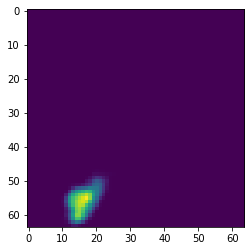

In [116]:
plt.imshow((seg3d==2).sum(0).sum(-1)[8:-56,48:-16])

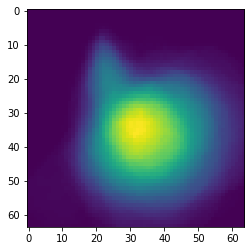

In [117]:
plt.imshow((seg3d==1).sum(0).sum(-1)[56:-8,48:-16])

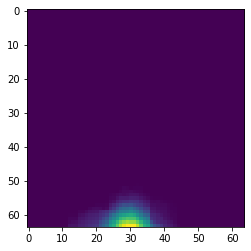

In [118]:
plt.imshow((seg3d==1).sum(0).sum(-2)[8:-56,40:-24])

In [119]:
moving_lenn = len(valid_t2)
_N = 4

best_all = torch.zeros_like(img3d)
best_n_all = torch.zeros_like(img3d).repeat(_N,1,1,1)
combined_all = torch.zeros_like(img3d)
multiple_all = torch.zeros_like(img3d).repeat(moving_lenn,1,1,1)

fixed_len = img3d.shape[0]

import time
t0 = time.time()
for fix in range(fixed_len):
    print(fix,time.time()-t0,'sec (total)')
    before = torch.zeros(moving_lenn,2)
    after = torch.zeros(moving_lenn,2)
    combined = torch.zeros(3,64,64,64)
    mov_all = torch.zeros(moving_lenn,128,128,128)

    for i in range(moving_lenn):
        disp = convexAdam(img3d[fix,56:-8,48:-16,40:-24],img3d_t2[i,56:-8,48:-16,40:-24])
        warped_one_hot = F.grid_sample(F.one_hot(seg3d_t2[i,56:-8,48:-16,40:-24].long(),3).permute(3,0,1,2).float().cuda().view(1,3,H,W,D),F.affine_grid(torch.eye(3,4).cuda().unsqueeze(0),(1,1,H,W,D))+disp.cuda(),mode='bilinear')
        combined += warped_one_hot.squeeze().cpu()
        warped_seg = warped_one_hot.argmax(1).squeeze()
        mov_all[i,56:-8,48:-16,40:-24] = warped_seg
        multiple_all[fix*i] = mov_all[i]
        before[i] = (dice_coeff(seg3d[fix,56:-8,48:-16,40:-24],seg3d_t2[i,56:-8,48:-16,40:-24],3))
        after[i] = (dice_coeff(seg3d[fix,56:-8,48:-16,40:-24],warped_seg.squeeze().cpu(),3))
    combined = F.avg_pool3d(F.avg_pool3d(F.avg_pool3d(combined.unsqueeze(0),3,stride=1,padding=1),3,stride=1,padding=1),3,stride=1,padding=1).squeeze()
    combined[0] *= 0.66
    print('before', before.mean(0), before.max(0)[0])
    print('after', after.mean(0), after.max(0)[0], after.min(0)[0],)
    print('combined', dice_coeff(seg3d[fix,56:-8,48:-16,40:-24], (combined[:,:,:,:].argmax(0)).squeeze().cpu(), 3))
    idx_best = torch.argmax(after[:,0])
    _, idx_best_n = after[:,1].topk(_N)
    best_all[fix] = mov_all[idx_best]
    best_n_all[fix*_N:(fix+1)*_N] = mov_all[idx_best_n]
    combined_all[fix,56:-8,48:-16,40:-24] = combined[:,:,:,:].argmax(0).cpu()

0 0.0006079673767089844 sec (total)


/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/torch/nn/functional.py:4043: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


before tensor([0.3380, 0.5127]) tensor([0.6481, 0.7113])
after tensor([0.5046, 0.4496]) tensor([0.8667, 0.5619]) tensor([0.0000, 0.2416])
combined tensor([0.7994, 0.4373])
1 9.106754779815674 sec (total)
before tensor([0.1036, 0.3853]) tensor([0.3723, 0.5042])
after tensor([0.1378, 0.3819]) tensor([0.5427, 0.4677]) tensor([0.0000, 0.2762])
combined tensor([0.2058, 0.3968])
2 18.594473123550415 sec (total)
before tensor([0.1672, 0.5298]) tensor([0.4667, 0.6609])
after tensor([0.2705, 0.4720]) tensor([0.7196, 0.6538]) tensor([0.0000, 0.2550])
combined tensor([0.2666, 0.3874])
3 27.266937255859375 sec (total)
before tensor([0.4186, 0.5803]) tensor([0.8167, 0.7670])
after tensor([0.5700, 0.4937]) tensor([0.8617, 0.6657]) tensor([0.0000, 0.3488])
combined tensor([0.8980, 0.4234])
4 36.773253202438354 sec (total)
before tensor([0.3197, 0.5645]) tensor([0.7183, 0.7030])
after tensor([0.4453, 0.4213]) tensor([0.8818, 0.6061]) tensor([0.0000, 0.2113])
combined tensor([0.5880, 0.3854])
5 46.4971

In [121]:
# torch.save({'combined_all':combined_all,'best_all':best_all,'valid_t1':valid_left_t1},'optimal_reg_right.pth')
save_str = "left" if LOAD_LEFT else "right"

file_ids = [f"{path}:var{int(idx/len(valid_t1))}" for idx, path in enumerate(valid_t1*moving_lenn)]

best_n_file_ids = []
for _path in valid_t1:
    for n in range(_N):
        best_n_file_ids.append(f"{_path}:var{n}")

nonempty_best_idxs = best_all.sum((-3,-2,-1)) > 0
nonempty_best_n_idxs = best_n_all.sum((-3,-2,-1)) > 0
nonempty_combined_idxs = combined_all.sum((-3,-2,-1)) > 0
nonempty_multiple_idxs = multiple_all.sum((-3,-2,-1)) > 0

print(f"Got {nonempty_best_idxs.sum().item()} 3d labels in 'best_1'")
print(f"Got {nonempty_best_n_idxs.sum().item()} 3d labels in 'best_n'")
print(f"Got {nonempty_combined_idxs.sum().item()} 3d labels in 'combined'")
print(f"Got {nonempty_multiple_idxs.sum().item()} 3d labels in 'multiple'")

torch.save(
    {
        'best_1': best_all[nonempty_best_idxs].to_sparse(),
        'best_n': best_n_all[nonempty_best_n_idxs].to_sparse(),
        'n': _N,
        'combined':combined_all[nonempty_combined_idxs].to_sparse(),
        'multiple':multiple_all[nonempty_multiple_idxs].to_sparse(),
        'best_1_files': [_path for _path, is_non_empty in zip(file_ids[:fixed_len], nonempty_best_idxs) if is_non_empty.item()],
        'best_n_files': [_path for _path, is_non_empty in zip(best_n_file_ids, nonempty_best_n_idxs) if is_non_empty.item()],
        'combined_files': [_path for _path, is_non_empty in zip(file_ids[:fixed_len], nonempty_combined_idxs) if is_non_empty.item()],
        'multiple_files': [_path for _path, is_non_empty in zip(file_ids, nonempty_multiple_idxs) if is_non_empty.item()]
    },
    f'multiple_reg_{save_str}.pth'
)
# !zip -r optimal_reg_right.zip optimal_reg_right.pth
# !zip -r multiple_reg_right.zip multiple_reg_right.pth 

Got 63 3d labels in 'best_1'
Got 252 3d labels in 'best_n'
Got 63 3d labels in 'combined'
Got 753 3d labels in 'multiple'


In [108]:
data = torch.load(f'multiple_reg_{save_str}.pth')
print(data.keys())
print(len(data['best_1_files']), len(data['best_n_files']), len(data['combined_files']), len(data['multiple_files']))

dict_keys(['best_1', 'best_n', 'n', 'combined', 'multiple', 'best_1_files', 'best_n_files', 'combined_files', 'multiple_files'])
44 176 44 520


In [109]:
print(data['best_n_files'])

['crossmoda_102_ceT1_l.nii.gz:var0', 'crossmoda_102_ceT1_l.nii.gz:var1', 'crossmoda_102_ceT1_l.nii.gz:var2', 'crossmoda_102_ceT1_l.nii.gz:var3', 'crossmoda_103_ceT1_l.nii.gz:var0', 'crossmoda_103_ceT1_l.nii.gz:var1', 'crossmoda_103_ceT1_l.nii.gz:var2', 'crossmoda_103_ceT1_l.nii.gz:var3', 'crossmoda_104_ceT1_l.nii.gz:var0', 'crossmoda_104_ceT1_l.nii.gz:var1', 'crossmoda_104_ceT1_l.nii.gz:var2', 'crossmoda_104_ceT1_l.nii.gz:var3', 'crossmoda_105_ceT1_l.nii.gz:var0', 'crossmoda_105_ceT1_l.nii.gz:var1', 'crossmoda_105_ceT1_l.nii.gz:var2', 'crossmoda_105_ceT1_l.nii.gz:var3', 'crossmoda_10_ceT1_l.nii.gz:var0', 'crossmoda_10_ceT1_l.nii.gz:var1', 'crossmoda_10_ceT1_l.nii.gz:var2', 'crossmoda_10_ceT1_l.nii.gz:var3', 'crossmoda_13_ceT1_l.nii.gz:var0', 'crossmoda_13_ceT1_l.nii.gz:var1', 'crossmoda_13_ceT1_l.nii.gz:var2', 'crossmoda_13_ceT1_l.nii.gz:var3', 'crossmoda_14_ceT1_l.nii.gz:var0', 'crossmoda_14_ceT1_l.nii.gz:var1', 'crossmoda_14_ceT1_l.nii.gz:var2', 'crossmoda_14_ceT1_l.nii.gz:var3', 'cr

In [ ]:
!ls -l optimal_reg_right.zip

In [ ]:
print('after',after.mean(0),after.max(0)[0],after.min(0)[0],)



In [ ]:
#

In [ ]:
for i in range(5,10):
    print(dice_coeff(seg3d[fix,8:-56,48:-16,40:-24],(combined[:,:,:,1]>i).squeeze().cpu(),3))

In [ ]:
plt.imshow(combined[:,:,32,1])
plt.colorbar()

In [ ]:
all_centre = torch.zeros(3,60)
cross_dice = torch.zeros(31,60,2)

all_warped2 = torch.zeros(31,96,96,96)#all_warped[2]/all_warped[3]*31


for nu1 in range(31):
    all_disp = torch.zeros(31,96,96,96,3)
    all_warped = torch.zeros(4,96,96,96)
    grid = torch.stack(torch.meshgrid((torch.arange(96),torch.arange(96),torch.arange(96)))).float()
    #print(grid.shape)
    centre0 = torch.sum(grid.view(3,-1)*(seg2d_t2[nu1*96:(1+nu1)*96]==2).view(1,-1).float(),1)/torch.sum(seg2d_t2[nu1*96:(1+nu1)*96]==2)
    all_dice = torch.zeros(2)
    torch.cuda.synchronize()
    t0 = time.time()
    for nu in range(60):
        img_fixed = img2d_t2[nu1*96:(1+nu1)*96].view(96,96,96)
        img_moving = img2d[nu*96:(nu+1)*96].view(96,96,96)
        
        all_disp[nu] = disp
        warped = F.grid_sample(seg2d[nu*96:(nu+1)*96].float().cuda().view(1,1,96,96,96),F.affine_grid(torch.eye(3,4).cuda().unsqueeze(0),(1,1,96,96,96))+disp.cuda(),mode='nearest')
        warped_onehot = F.grid_sample(F.one_hot(seg2d[nu*96:(nu+1)*96],3).permute(3,0,1,2).float().cuda().view(1,3,96,96,96),F.affine_grid(torch.eye(3,4).cuda().unsqueeze(0),(1,1,96,96,96))+disp.cuda(),mode='bilinear')
        warped_mind = F.grid_sample(mindssc_mov.float(),F.affine_grid(torch.eye(3,4).cuda().unsqueeze(0),(1,1,96,96,96))+disp.cuda(),mode='bilinear')


        similarity = torch.exp(-1.5*F.avg_pool3d((mindssc_fix-warped_mind).pow(2),1,stride=1,padding=0).sum(1).squeeze(0))


        #print(dice_coeff(seg2d[nu1*96:(1+nu1)*96],seg2d_t2[nu*96:(nu+1)*96],3))
        #nib.save(nib.Nifti1Image(warped.squeeze().byte().cpu().data.numpy(),np.eye(4)),'crossmoda_reg_F'+str(nu1)+'_T2_M'+str(nu)+'_T1.nii.gz')
        all_warped[:3] += (similarity*warped_onehot).squeeze(0).cpu()#F.one_hot(warped.squeeze().long(),3).cpu().permute(3,0,1,2)
        all_warped[3] += similarity.squeeze().cpu()
        d = (dice_coeff(seg2d_t2[nu1*96:(1+nu1)*96],warped.squeeze().cpu(),3))
        all_dice += d
        cross_dice[nu1,nu] = d
    centre = torch.sum(grid.view(3,-1)*(all_warped[2]).view(1,-1).float(),1)/torch.sum(all_warped[2])
    print('localisation',centre,(centre-centre0).norm(),'dice',all_dice/40)
    torch.cuda.synchronize()
    t1 = time.time()
    print('time for 31 registrations',t1-t0,'sec')
    all_centre[:,nu1] = centre
    all_warped2[nu1] = all_warped[2]/all_warped[3]*31
    